In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
path = '/kaggle/input/seismic-data/data/lunar/training/data/S12_GradeA/'

all_files = glob.glob(os.path.join(path, "*.csv"))

In [3]:
# Get all CSV files in the directory
all_files = glob.glob(os.path.join(path, "*.csv"))

# Read and concatenate all CSV files
df_list = []
for file in all_files:
    df = pd.read_csv(file, parse_dates=['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

# Basic statistics
print(combined_df.describe())

      time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
count                       43175429   4.317543e+07   4.317543e+07
mean   1972-07-23 10:35:06.103111424   4.298187e+04  -7.625022e-13
min       1970-01-19 00:00:00.665000   0.000000e+00  -1.496286e-07
25%       1971-02-09 20:33:38.443151   2.143758e+04  -9.761695e-11
50%    1972-07-17 22:36:25.995320992   4.287517e+04  -1.511219e-18
75%    1973-08-21 03:26:05.935019008   6.448136e+04   9.754271e-11
max       1975-06-27 00:00:01.447660   8.640392e+04   1.473143e-07
std                              NaN   2.489443e+04   1.209250e-09


In [4]:
combined_df = combined_df.head(1000000)

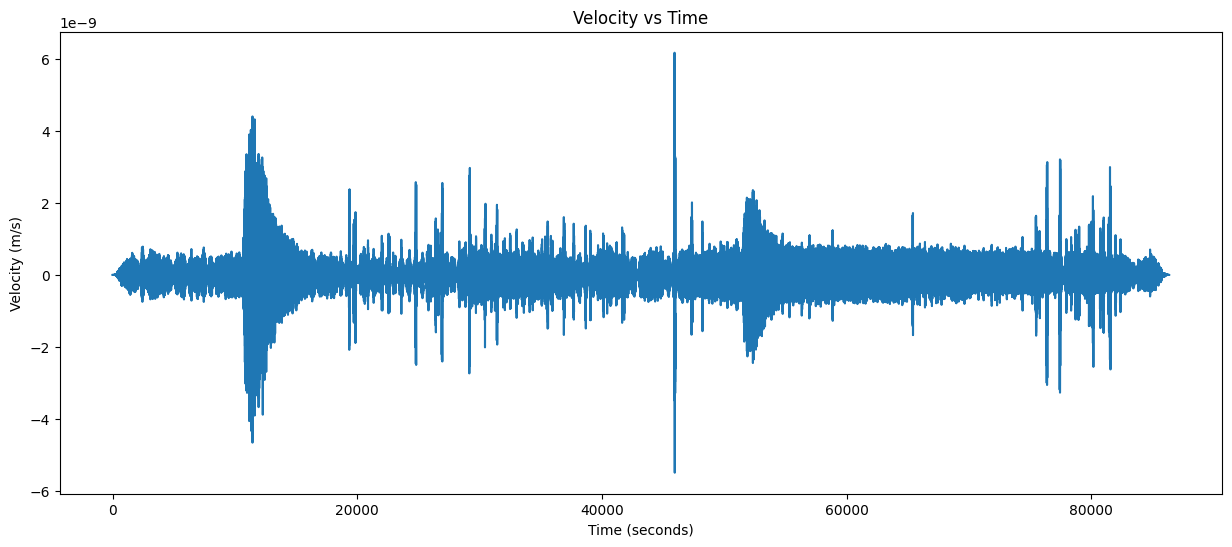

In [5]:
# Plot the velocity over time
plt.figure(figsize=(15, 6))
plt.plot(combined_df['time_rel(sec)'], combined_df['velocity(m/s)'])
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.show()

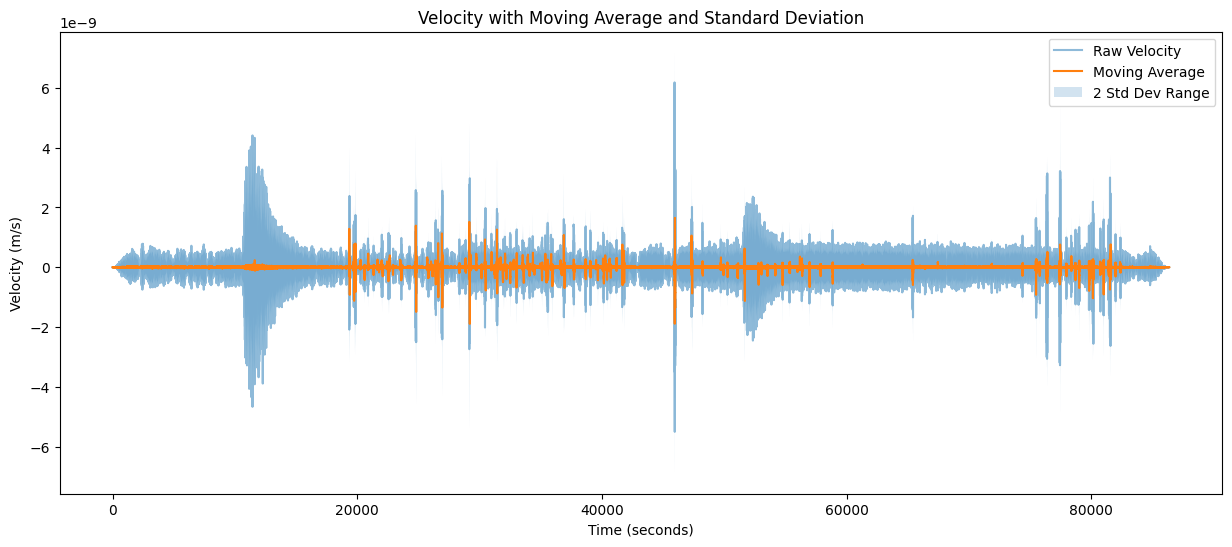

In [6]:
# Calculate the moving average and standard deviation
window_size = 100  # Adjust this based on your data
combined_df['velocity_ma'] = combined_df['velocity(m/s)'].rolling(window=window_size).mean()
combined_df['velocity_std'] = combined_df['velocity(m/s)'].rolling(window=window_size).std()

# Plot the moving average and standard deviation
plt.figure(figsize=(15, 6))
plt.plot(combined_df['time_rel(sec)'], combined_df['velocity(m/s)'], alpha=0.5, label='Raw Velocity')
plt.plot(combined_df['time_rel(sec)'], combined_df['velocity_ma'], label='Moving Average')
plt.fill_between(combined_df['time_rel(sec)'], 
                 combined_df['velocity_ma'] - 2*combined_df['velocity_std'], 
                 combined_df['velocity_ma'] + 2*combined_df['velocity_std'], 
                 alpha=0.2, label='2 Std Dev Range')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity with Moving Average and Standard Deviation')
plt.legend()
plt.show()

Number of data points in potential seismic events: 13676
Number of distinct event periods: 10


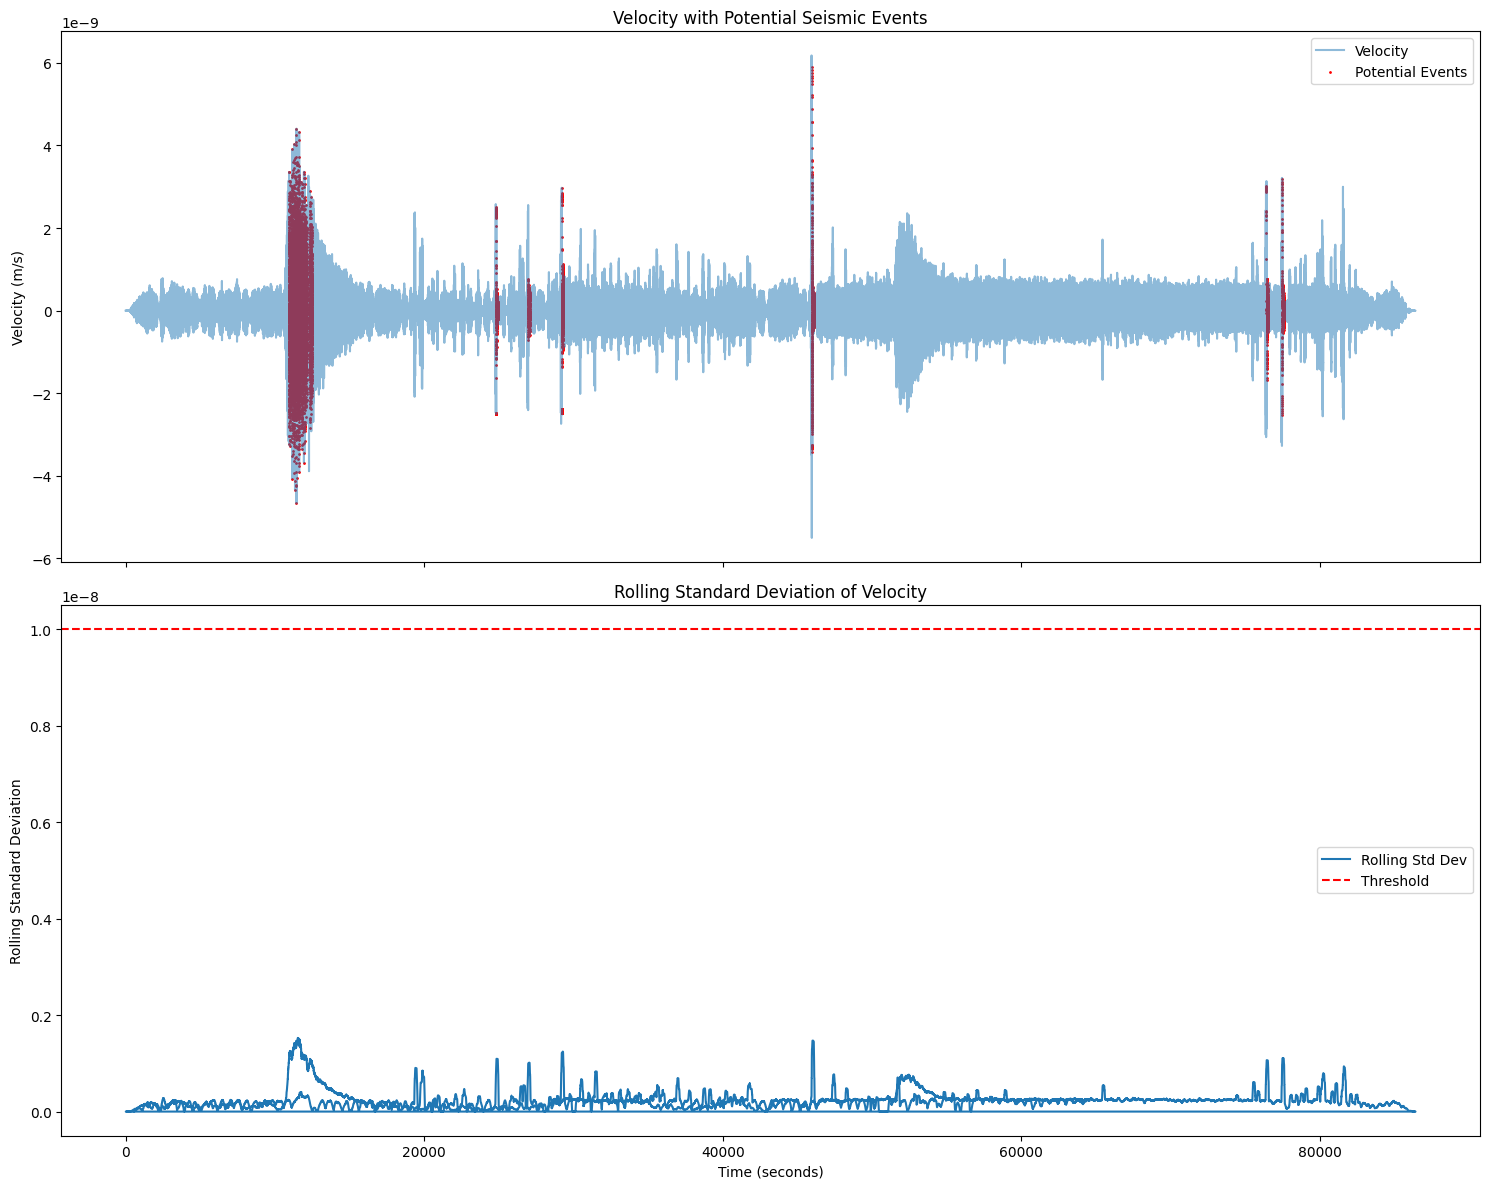

Average event duration: 1367.60 data points
Longest event duration: 8088 data points
Shortest event duration: 10 data points


In [7]:
events = []

def detect_events(df, window_size=1000, fluctuation_threshold=1e-9, min_duration=10):
    # Calculate rolling standard deviation
    df['rolling_std'] = df['velocity(m/s)'].rolling(window=window_size).std()
    
    # Identify periods of high fluctuation
    high_fluctuation = df['rolling_std'] > fluctuation_threshold
    
    # Label events
    event_start = None
    for i, is_fluctuating in enumerate(high_fluctuation):
        if is_fluctuating and event_start is None:
            event_start = i
        elif not is_fluctuating and event_start is not None:
            if i - event_start >= min_duration:
                events.append((event_start, i))
            event_start = None
    
    # Handle case where the last event extends to the end of the data
    if event_start is not None and len(df) - event_start >= min_duration:
        events.append((event_start, len(df)))
    
    # Create a mask for all event periods
    event_mask = np.zeros(len(df), dtype=bool)
    for start, end in events:
        event_mask[start:end] = True
    
    return df[event_mask], events

# Assuming combined_df is your DataFrame with the seismic data
potential_events, event_periods = detect_events(combined_df)
print(f"Number of data points in potential seismic events: {len(potential_events)}")
print(f"Number of distinct event periods: {len(event_periods)}")

# Plot detected events and rolling standard deviation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot velocity and events
ax1.plot(combined_df['time_rel(sec)'], combined_df['velocity(m/s)'], alpha=0.5, label='Velocity')
ax1.scatter(potential_events['time_rel(sec)'], potential_events['velocity(m/s)'], 
            color='red', s=1, label='Potential Events')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity with Potential Seismic Events')
ax1.legend()

# Plot rolling standard deviation
ax2.plot(combined_df['time_rel(sec)'], combined_df['rolling_std'], label='Rolling Std Dev')
ax2.axhline(y=1e-8, color='r', linestyle='--', label='Threshold')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Rolling Standard Deviation')
ax2.set_title('Rolling Standard Deviation of Velocity')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some statistics about the events
if event_periods:
    durations = [(end - start) for start, end in event_periods]
    print(f"Average event duration: {np.mean(durations):.2f} data points")
    print(f"Longest event duration: {max(durations)} data points")
    print(f"Shortest event duration: {min(durations)} data points")

In [9]:
def create_features(df, window_size=100):
    """Create features for the model."""
    df['rolling_mean'] = df['velocity(m/s)'].rolling(window=window_size).mean()
    df['rolling_std'] = df['velocity(m/s)'].rolling(window=window_size).std()
    df['rolling_max'] = df['velocity(m/s)'].rolling(window=window_size).max()
    df['rolling_min'] = df['velocity(m/s)'].rolling(window=window_size).min()
    return df.dropna()

def label_events(df, events):
    """Label data points as event (1) or non-event (0)."""
    df['event'] = 0
    for start, end in events:
        df.loc[start:end, 'event'] = 1
    return df

def train_model(X, y):
    """Train a Random Forest model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    return model, scaler, X_test_scaled, y_test

In [10]:
df_features = create_features(combined_df.copy())
df_labeled = label_events(df_features, events)

In [11]:
# Prepare data for modeling
features = ['rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']
X = df_labeled[features]
y = df_labeled['event']

In [12]:
# Train and evaluate the model
model, scaler, X_test_scaled, y_test = train_model(X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    197219
           1       0.99      0.97      0.98      2762

    accuracy                           1.00    199981
   macro avg       1.00      0.99      0.99    199981
weighted avg       1.00      1.00      1.00    199981


Confusion Matrix:
[[197194     25]
 [    75   2687]]


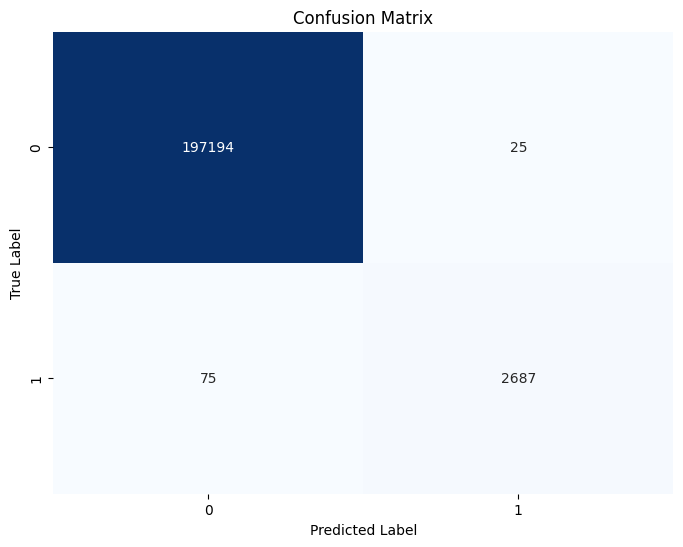

In [13]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print metrics and plot confusion matrix."""
    # Get predictions
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


evaluate_model(model, X_test_scaled, y_test)

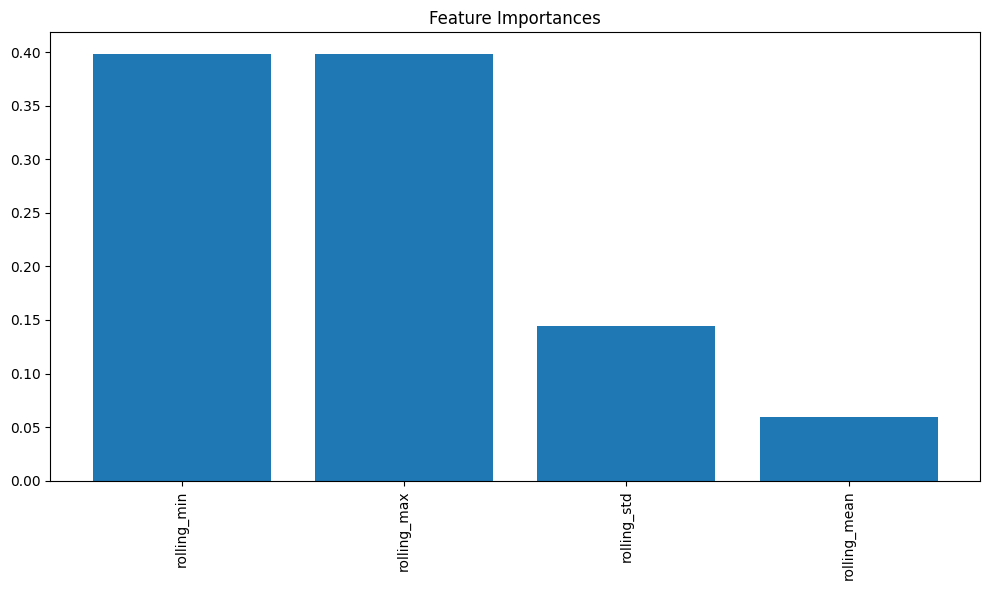

In [14]:
def plot_feature_importance(model, feature_names):
    """Plot feature importance."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model, features)

In [21]:
def predict_seismic_events(velocity_array, window_size=100, threshold=0.8):
    """
    Predict seismic events based on velocity data with a probability threshold.
    
    Parameters:
    velocity_array (array-like): Array of velocity measurements
    window_size (int): Size of the rolling window for feature creation
    threshold (float): Probability threshold for classifying events (default: 0.8)
    
    Returns:
    tuple: (predictions, probabilities)
    """
    # Create DataFrame
    df = pd.DataFrame({'velocity(m/s)': velocity_array})
    
    # Create features
    df['rolling_mean'] = df['velocity(m/s)'].rolling(window=window_size).mean()
    df['rolling_std'] = df['velocity(m/s)'].rolling(window=window_size).std()
    df['rolling_max'] = df['velocity(m/s)'].rolling(window=window_size).max()
    df['rolling_min'] = df['velocity(m/s)'].rolling(window=window_size).min()
    df = df.dropna()
    
    # Prepare features for prediction
    features = df[['rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']]
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Create and train model (you would typically train this on historical data)
    model = RandomForestClassifier(random_state=42)
    # In a real scenario, you would train the model on labeled historical data
    # For this example, we'll just fit it to random data
    random_labels = np.random.randint(0, 2, size=len(features_scaled))
    model.fit(features_scaled, random_labels)
    
    # Get probabilities
    probabilities = model.predict_proba(features_scaled)[:, 1]
    
    # Apply threshold to get predictions
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

In [18]:
#Let's test the model on unknown data
test_val_array= pd.read_csv('/kaggle/input/seismic-data/data/lunar/test/data/S16_GradeB/xa.s16.00.mhz.1973-12-18HR00_evid00487.csv')['velocity(m/s)'].head(200)

Predictions: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0]
Probabilities: [0.22 0.72 0.91 0.84 0.2  0.11 0.12 0.01 0.01 0.   0.   0.02 0.04 0.02
 0.12 0.75 0.95 0.83 0.34 0.74 0.39 0.56 0.14 0.26 0.83 0.69 0.11 0.11
 0.72 0.44 0.92 0.71 0.37 0.92 0.77 0.86 0.86 0.26 0.75 0.87 0.27 0.78
 0.93 0.95 0.32 0.19 0.68 0.2  0.05 0.13 0.63 0.13 0.1  0.13 0.13 0.19
 0.76 0.36 0.96 0.83 0.74 0.2  0.07 0.08 0.75 0.89 0.83 0.95 0.95 0.97
 0.78 0.26 0.61 0.23 0.13 0.74 0.95 0.72 0.38 0.7  0.24 0.17 0.29 0.79
 0.95 0.81 0.72 0.83 0.34 0.24 0.87 0.91 0.35 0.76 0.89 0.84 0.17 0.24
 0.86 0.86 0.3 ]


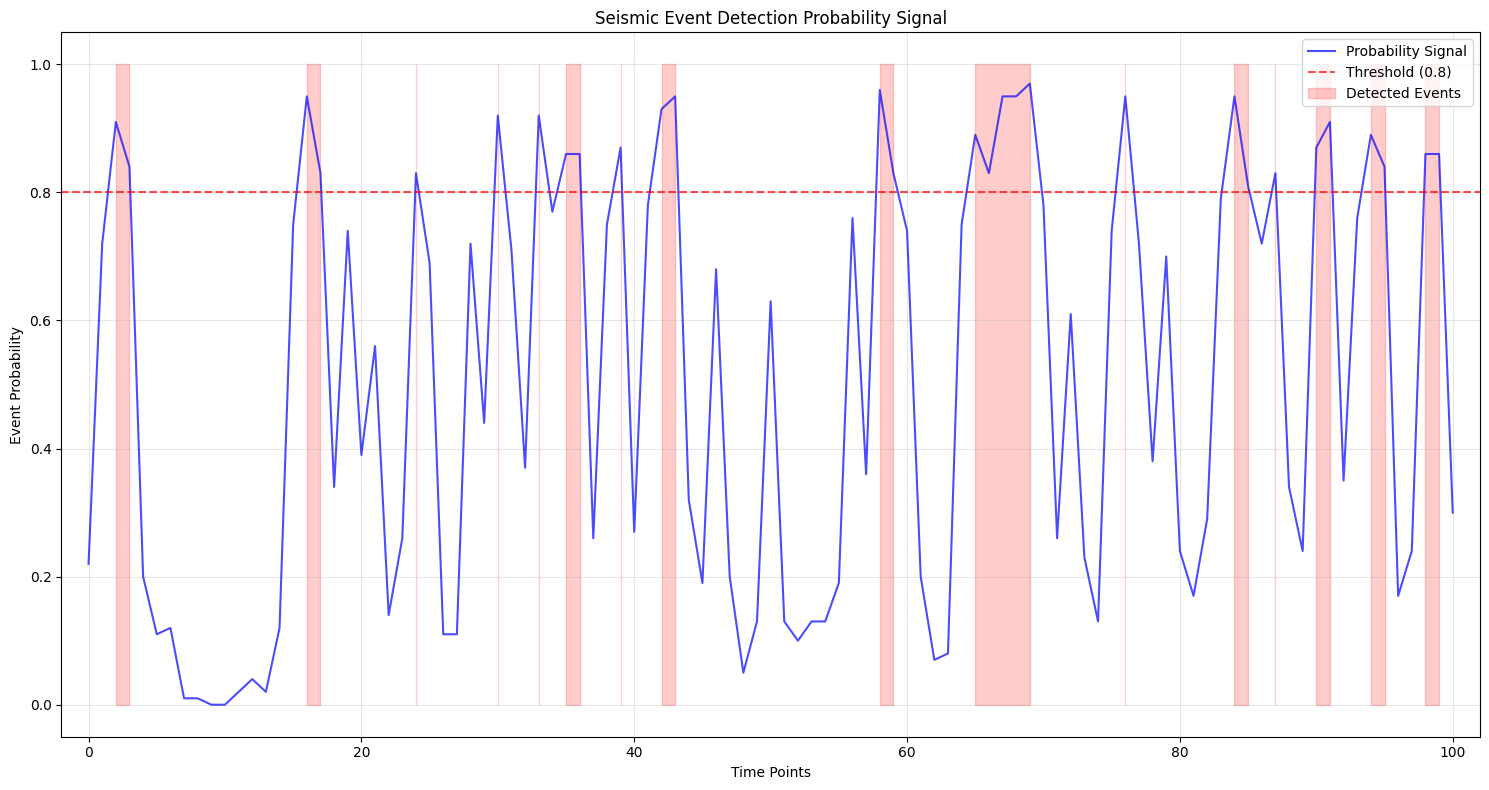

In [23]:
# After your existing code:
velocity_data = test_val_array.to_numpy()
predictions, probabilities = predict_seismic_events(velocity_data)
print("Predictions:", predictions)
print("Probabilities:", probabilities)

# Create the visualization
plt.figure(figsize=(15, 8))

# Plot the probability signal
time_points = np.arange(len(probabilities))
plt.plot(time_points, probabilities, label='Probability Signal', color='blue', alpha=0.7)

# Add threshold line
threshold = 0.8
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})', alpha=0.7)

# Highlight detected events
event_mask = probabilities >= threshold
plt.fill_between(time_points, 0, 1, where=event_mask, color='red', alpha=0.2, label='Detected Events')

# Customize the plot
plt.xlabel('Time Points')
plt.ylabel('Event Probability')
plt.title('Seismic Event Detection Probability Signal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(-0.05, 1.05)  # Set y-axis limits with small padding

# Add some padding to x-axis
plt.margins(x=0.02)

plt.tight_layout()
plt.show()